# Assigment 3: Kernels and SVMs

Juan Navarro, <jsnavarroa@unal.edu.co>

## 1. Let $ x = \{x_1 , . . . , x_n \} $ be a subset of a input data set X. Consider a kernel function $ k : X×X → R $, which induces a feature space $ \phi(X) $:

(a) Deduce an expression, that allows to calculate the average distance to the center of mass
of the image of set x in the feature space (notice that the norm is **not** squared):

$$ \large \frac{1}{n} \sum_{i=1}^{n} {\Vert \phi(x_i ) − \phi_S(x) \Vert }_{\phi(X)} , $$

where the center of mass is defined as

$$ \large \phi_S(x) =  \frac{1}{n} \sum_{i=1}^{n} \phi(x_i ) $$

(b) Use the previous expression to calculate the average distance to the center of mass of
the following point set in R 2 , x = {(0, 1), (−1, 3), (2, 4), (3, −1), (−1, −2)}, in the feature
spaces induced by the following kernels:

    i. k(x, y) = hx, yi

    ii. k(x, y) = hx, yi 2

    iii. k(x, y) = (hx, yi + 1) 5

    iv. Gaussian kernel with σ = 1.

## 2. Digit recognition model understanding.

(a) Get the data for the MNIST data set: http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./data/')

mnist.data.shape

(70000, 784)

(b) Normalize your features so that each one has mean 0 and standard deviation 1.

/home/juan/Programas/Miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


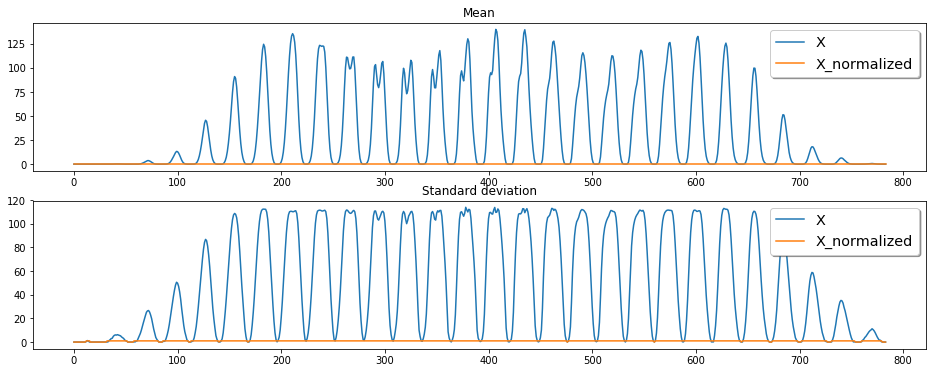

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

X = mnist.data
y = mnist.target


scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Plot the mean and standard deviation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6))

ax1.set_title('Mean')
ax1.plot(np.mean(X, axis=0), label='X')
ax1.plot(np.mean(X_norm, axis=0), label='X_normalized')
ax1.legend(loc='upper right', shadow=True, fontsize='x-large')

ax2.set_title('Standard deviation')
ax2.plot(np.std(X, axis=0), label='X')
ax2.plot(np.std(X_norm, axis=0), label='X_normalized')
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.show()

(c) Choose two classes (e.g. 1 and 0, or 6 and 9) and train a linear SVM to discriminate between them. Find an optimal complexity parameter, C, plotting the training and test error vs. the regularization parameter. Use a logarithmic scale for C, $ \{2^{−15} , 2^{−4} , . . . , 2^{10} \} $.
Discuss the results.

Optimal C 0.0071968567300115215


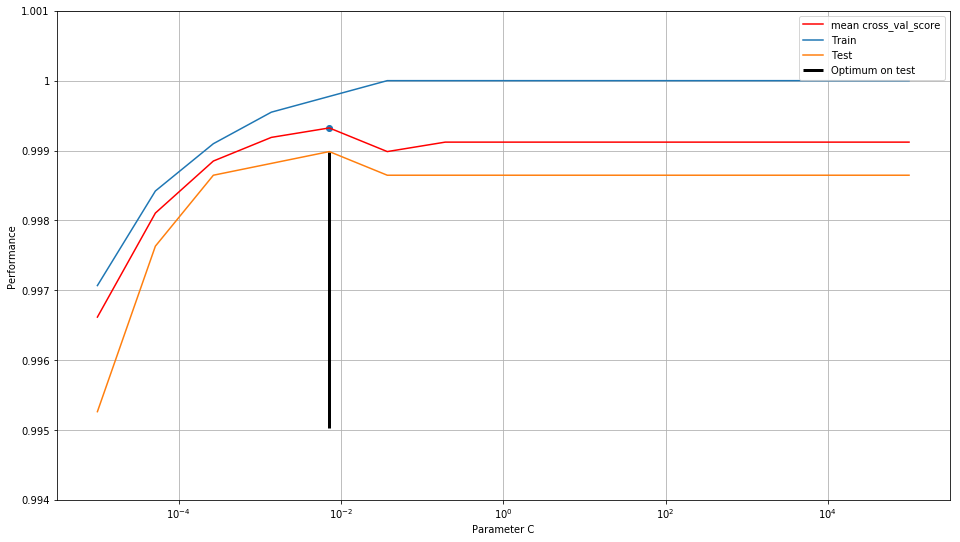

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

def getSubset(X, y, digits_to_use):
    # Get samples from 0 and 1 digits
    ix = np.isin(y, digits_to_use)
    X_subset = X[ix]
    y_subset = y[ix]
    
    return X_subset, y_subset
    

def getOptimalC(X, y, plot=False):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

    C_s = np.logspace(start=-5, stop=5, num=15, base=10)

    # Score the classifier
    scores = list()
    scores_std = list()
    train_errors = list()
    test_errors = list()
    
    for C in C_s:
        # Create a classifier: a support vector classifier
        classifier = svm.SVC(kernel='linear', C=C)
        
        # Cross validation score
        this_scores = cross_val_score(classifier, X, y, n_jobs=-1)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))
        
        # Train and test errors
        classifier.fit(X_train, y_train)
        train_errors.append(classifier.score(X_train, y_train))
        test_errors.append(classifier.score(X_test, y_test))
        

    # Optimal C
    C_optimal = C_s[np.array(scores).argmax()]
    
    i_alpha_optim = np.argmax(test_errors)
    alpha_optim = C_s[i_alpha_optim]
    print("Optimal C", C_optimal)

    # Do the plotting
    if plot:
        plt.figure(1, figsize=(16, 9))
        plt.clf()
        
        plt.semilogx(C_s, scores, 'r', label='mean cross_val_score')
        #plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
        #plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
        
        plt.semilogx(C_s, np.array(train_errors), label='Train')
        plt.semilogx(C_s, np.array(test_errors), label='Test')
        
        plt.scatter(C_optimal, scores[np.array(scores).argmax()], marker='o', cmap=plt.cm.Spectral)
        plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k', linewidth=3, label='Optimum on test')

        locs, labels = plt.yticks()
        plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
        plt.ylabel('Performance')
        plt.xlabel('Parameter C')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    
    return C_optimal


X_subset, y_subset = getSubset(X_norm, y, [0, 1])

C_optimal = getOptimalC(X_subset, y_subset, plot=True)

(d) Extract the weights of the classification model found in (b).

In [4]:
def getWeights(X, y, C):
    clf =svm.SVC(kernel='linear', C=C)
    clf.fit(X, y)

    # Weights assigned to the features (coefficients in the primal problem). 
    # This is only available in the case of a linear kernel.
    return clf.coef_

weights = getWeights(X_subset, y_subset, C_optimal)

weights.shape

(1, 784)

(e) Plot the discriminant function weights as follows:

i. Arrange the weights in a matrix with the same shape as the input image.
  
ii. Use a function such as pcolor http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolor to produce a color plot of the matrix.iii. Use a diverging colormap that emphasizes negative and positive values http://matplotlib.org/examples/color/colormaps_reference.html.
  
iv. Discuss the results.
  

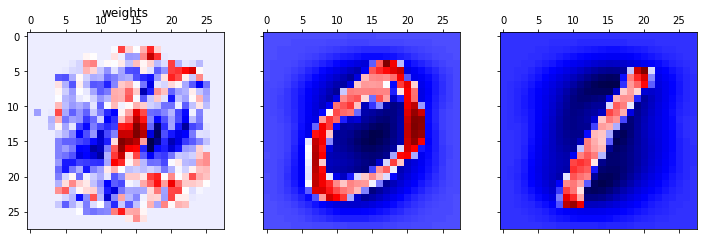

In [5]:
image_size = (28, 28)
cmap = plt.cm.seismic

def plotWeights(weights, X, y):
    weights = np.reshape(weights, image_size)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

    d = np.unique(y)

    # Get an example of each one
    example0 = X[np.argmax(y==d[0])]
    example1 = X[np.argmax(y==d[1])]

    # Plot the weights and the examples
    ax1.matshow(weights, cmap=cmap)
    ax1.set_title("weights")
    ax2.matshow(np.reshape(example0, image_size), cmap=cmap)
    ax3.matshow(np.reshape(example1, image_size), cmap=cmap)

    plt.show()

plotWeights(weights, X_subset, y_subset)

# The weights with bigger absolute values indicate the most relevant features for the discrimination. 
# In this case, the positive ones for the 1 class and the negative ones for the 0 class.

(f) Play with different pairs of digits and with different values for the C parameter (smaller
values could produce smoother plots). Discuss the results.

Optimal C 0.037275937203149416


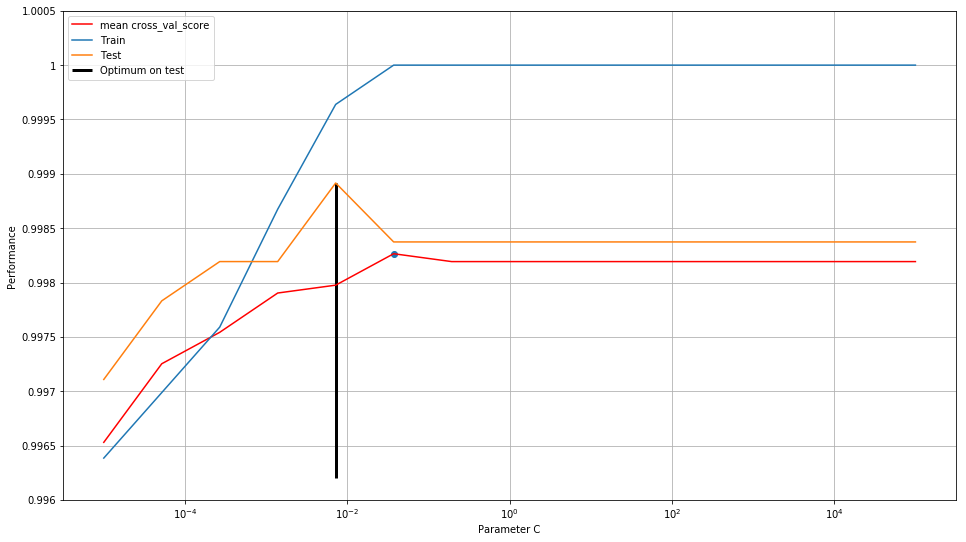

In [6]:
X_subset, y_subset = getSubset(X_norm, y, [6, 9])

C_optimal = getOptimalC(X_subset, y_subset, plot=True)

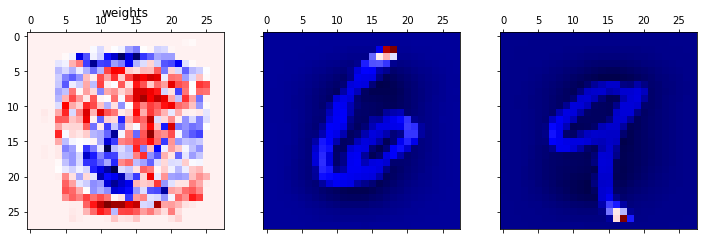

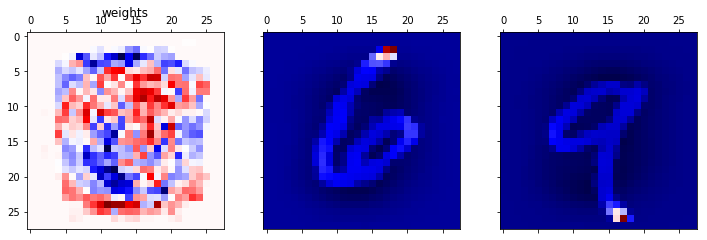

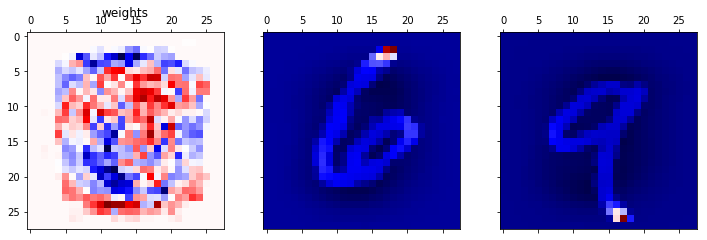

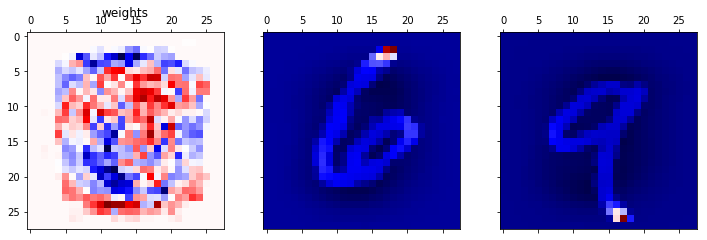

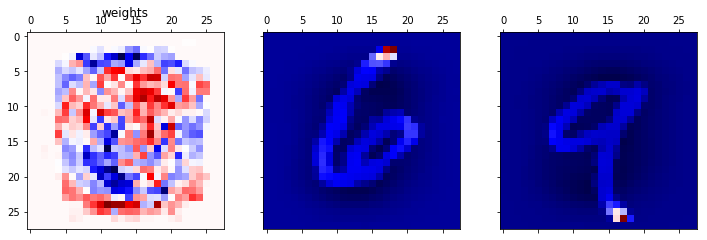

In [7]:
for d in np.arange(0, 100, step=20):
    weights = getWeights(X_subset, y_subset, C_optimal+d)
    plotWeights(weights, X_subset, y_subset)

## 3. Train an SVM for detecting whether a word belongs to English or Spanish.

(a) Build training and test data sets. You can use the most frequent words in http://en.wiktionary.org/wiki/Wiktionary:Frequency_lists. Consider words at least 4
characters long and ignore accents.

In [8]:
import os
import urllib
import pandas as pd

def downloadTxtFile(url, filename):
    
    path = "./data/"+str(filename)
    
    if os.path.isfile(path):
        # Load downloaded files
        data = open(path).read()
    
    else:
        # Load from URL and save to file
        with urllib.request.urlopen(url) as response:
            data = response.read().decode()
            file = open(path, "w")
            file.write(data)
            file.close()
    
    df = pd.read_csv(path, sep=" ", header=None)
    
    return df
    

# From https://github.com/hermitdave/FrequencyWords
en_url = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/en/en_50k.txt"
en_file = "en_50k.txt"
es_url = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/es/es_50k.txt"
es_file = "es_50k.txt"

en_df = downloadTxtFile(en_url, en_file)
en_df['lang'] = "English"

es_df = downloadTxtFile(es_url, es_file)
es_df['lang'] = "Spanish"

words = en_df.append(es_df)
words.reset_index(drop=True)

words.columns = ['word', 'occurrences', 'lang']
words.drop('occurrences', axis=1, inplace=True)
words.dropna(axis=0, how='any', inplace=True)

# Drop words with less than 4 characters
words = words.loc[words['word'].str.len() >= 4]

# Ignore accents


words.to_csv("./data/words.csv")

words.describe(include="all")

,word,lang
count,95842,95842
unique,85038,2
top,electro,Spanish
freq,2,48414


In [9]:
words.loc[words['word'].str.contains('á')].head()

,word,lang
10749,sátur,English
22953,tomás,English
23390,está,English
28002,hernán,English
28419,julián,English


(b) Implement the kernel proposed by Lodhi et al. [1] as well as a kernel that counts the
number of common n-grams between two strings. Alternatively use the implementation
in https://github.com/muggin/string-kernels.

In [10]:
import stringkernels

ModuleNotFoundError: No module named 'stringkernels'

(c) Use scikit-learn to train different SVMs using precomputed kernels. Use cross valida-
tion to find appropriate regularization parameters. Try different configurations of the
parameters (λ and n).

(d) Evaluate the performance of the SVMs in the test data set:

i. Report the results in a table for the different evaluated configurations.

ii. Illustrate examples of errors (English words mistaken as Spanish, Spanish words
mistaken as English). Give a possible explanation for these mistakes.

iii. Discuss the results.

## References
[1] Lodhi, H., Saunders, C., Shawe-Taylor, J., Cristianini, N., & Watkins, C. (2002). Text classification using string kernels. Journal of Machine Learning Research, 2(Feb), 419-444.